# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [167]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
traffic-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  traffic-dataset.zip
replace Traffic Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [168]:
# Libraries for DA:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
# Import needed modules:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, QuantileTransformer, PowerTransformer, StandardScaler,OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN # Incase of binning we'll cluster our data into clusters.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
# Import needed modules for RNN model:
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Conv1D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping # If im willing to go all in I'll deploy the model.

In [169]:
df = pd.read_csv('/content/Traffic Data.csv', parse_dates = ['date_time'], index_col = 'date_time')

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20000 entries, 2017-08-27 01:00:00 to 2018-05-31 18:00:00
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.2+ MB


In [171]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2017-08-27 01:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2018-09-06 23:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2017-08-25 18:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2017-11-09 22:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2017-11-09 15:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [172]:
df.tail()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2018-06-06 21:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds
2017-10-25 15:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds
2018-03-28 23:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear
2018-02-12 15:00:00,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds
2018-05-31 18:00:00,5042.0,301.65,0.0,0.0,40,Clouds,scattered clouds


In [173]:
# As we observe in our data we notice that our index is not sorted, so we'll sort it:
df.index = df.index.sort_values()

In [174]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,1209.0,291.15,0.0,0.0,90,Mist,mist
2016-11-18 15:00:00,1248.0,286.01,0.0,0.0,1,Clear,sky is clear
2016-11-18 15:00:00,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds
2016-11-18 16:00:00,2838.0,262.35,0.0,0.0,1,Clear,sky is clear
2016-11-18 16:00:00,5794.0,267.08,0.0,0.0,5,Clear,sky is clear


In [175]:
df.tail()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2018-09-30 19:00:00,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds
2018-09-30 20:00:00,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds
2018-09-30 21:00:00,1132.0,275.30,0.0,0.0,1,Clear,sky is clear
2018-09-30 22:00:00,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds
2018-09-30 23:00:00,5042.0,301.65,0.0,0.0,40,Clouds,scattered clouds


In [176]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [177]:
# Let's observe the correlation between the weather and the traffic volume statistically:
df.groupby('weather_main').describe().transpose()

weather_main                 Clear       Clouds      Drizzle           Fog  \
traffic_volume count   5606.000000  5231.000000   991.000000    478.000000   
               mean    2999.473243  3880.587459  3282.547931   2687.861925   
               std     2008.430135  1788.924346  1980.910700   2113.434327   
               min      186.000000   219.000000   113.000000    151.000000   
               25%      888.000000  2773.500000  1277.000000    811.250000   
               50%     2998.500000  4377.000000  3489.000000   2133.000000   
               75%     4815.000000  5132.500000  4902.500000   4515.500000   
               max    10843.000000  7280.000000  6863.000000  10309.000000   
temp           count   5614.000000  5234.000000   993.000000    478.000000   
               mean     279.629899   283.546002   283.987925    279.426276   
               std       14.420452    12.477766     7.410898      9.422773   
               min      244.220000   249.290000   265.490000    246.740000   
               25%      269.082500   273.542500   276.420000    272.150000   
               50%      280.880000   284.550000   283.840000    275.770000   
               75%      291.897500   294.477500   291.080000    288.927500   
               max      308.430000   310.070000   301.490000    294.580000   
rain_1h        count   5614.000000  5234.000000   993.000000    478.000000   
               mean       0.000000     0.000000     0.068741      0.062259   
               std        0.000000     0.000000     0.409646      0.531154   
               min        0.000000     0.000000     0.000000      0.000000   
               25%        0.000000     0.000000     0.000000      0.000000   
               50%        0.000000     0.000000     0.000000      0.000000   
               75%        0.000000     0.000000     0.000000      0.000000   
               max        0.000000     0.000000     7.110000      9.620000   
snow_1h        count   5614.000000  5234.000000   993.000000    478.000000   
               mean       0.000000     0.000000     0.000000      0.000000   
               std        0.000000     0.000000     0.000000      0.000000   
               min        0.000000     0.000000     0.000000      0.000000   
               25%        0.000000     0.000000     0.000000      0.000000   
               50%        0.000000     0.000000     0.000000      0.000000   
               75%        0.000000     0.000000     0.000000      0.000000   
               max        0.000000     0.000000     0.000000      0.000000   
clouds_all     count   5614.000000  5234.000000   993.000000    478.000000   
               mean       1.620770    65.302254    81.088620     49.841004   
               std        1.512677    24.336005    22.391769     42.493159   
               min        0.000000    12.000000     1.000000      1.000000   
               25%        1.000000    40.000000    90.000000      1.000000   
               50%        1.000000    75.000000    90.000000     75.000000   
               75%        1.000000    90.000000    90.000000     90.000000   
               max        8.000000    92.000000    92.000000     92.000000   

weather_main                 Haze          Mist         Rain        Smoke  \
traffic_volume count   672.000000   2756.000000  2240.000000     3.000000   
               mean   3328.693452   2908.473875  3349.714286  4946.000000   
               std    1918.539062   2052.182122  1943.420004   871.235904   
               min     207.000000    113.000000   113.000000  4438.000000   
               25%    1306.500000    851.000000  1506.000000  4443.000000   
               50%    3760.500000   2817.000000  3584.000000  4448.000000   
               75%    4911.250000   4734.000000  4911.250000  5200.000000   
               max    7042.000000  16781.000000  7149.000000  5952.000000   
temp           count   672.000000   2758.000000  2244.000000     3.000000   
               mean    275.1905

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [178]:
# Let's explore our data a bit more:
for col in df.columns:
  print(f'Unique values for feature {col} of type {df[col].dtype}:')
  print("Number of unique vlaues:", df[col].nunique())
  print(df[col].unique())
  print(f'The value counts: {df[col].value_counts()}')
  print('-'*100)

Unique values for feature traffic_volume of type float64:
Number of unique vlaues: 5754
[1209. 1248. 4602. ... 6742. 1783. 1132.]
The value counts: traffic_volume
353.0     29
344.0     22
373.0     22
340.0     22
358.0     22
          ..
1359.0     1
5607.0     1
4368.0     1
3459.0     1
6385.0     1
Name: count, Length: 5754, dtype: int64
----------------------------------------------------------------------------------------------------
Unique values for feature temp of type float64:
Number of unique vlaues: 3901
[291.15 286.01 293.69 ... 249.88 269.23 289.06]
The value counts: temp
274.15    93
275.15    65
274.08    63
291.15    58
292.15    52
          ..
299.96     1
295.64     1
255.69     1
306.28     1
265.47     1
Name: count, Length: 3901, dtype: int64
----------------------------------------------------------------------------------------------------
Unique values for feature rain_1h of type float64:
Number of unique vlaues: 87
[ 0.    0.25  1.78  2.79  0.44  2.26  0.2

In [179]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [180]:
df.duplicated().sum()

18

In [181]:
# Check whether those duplicates are real or not:
duplicates = df[df.duplicated(keep = False)]
duplicates

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-27 09:00:00,629.0,278.720,0.0,0.0,90,Drizzle,light intensity drizzle
2016-12-02 05:00:00,420.0,254.220,0.0,0.0,1,Clear,sky is clear
2016-12-20 21:00:00,5263.0,296.950,0.0,0.0,1,Thunderstorm,thunderstorm
2016-12-23 01:00:00,249.0,255.420,0.0,0.0,1,Clear,sky is clear
2017-01-02 20:00:00,4725.0,294.520,0.0,0.0,1,Clear,sky is clear
2017-01-05 07:00:00,249.0,255.420,0.0,0.0,1,Clear,sky is clear
2017-01-31 00:00:00,4498.0,288.890,0.0,0.0,1,Clear,sky is clear
2017-02-01 05:00:00,388.0,274.710,0.0,0.0,90,Mist,mist
2017-03-16 14:00:00,5263.0,296.950,0.0,0.0,1,Thunderstorm,thunderstorm


In [182]:
# After our extensive EDA we notice the following:
# 1- The snow_1h feature has no unique or significant data recorded as all data recorded of snow in mm = 0 so it shall be dropped..
# 2- The traffic volume data type should be transformed into an integer rather than float.
# 3- Data should be checked for outliers, if found use a quantile transformer to handle it.
# 4- Duplicates are real and not the result of an error.

In [183]:
# Dropping snow_1h:
df.drop('snow_1h', axis = 1, inplace = True)

In [184]:
# We'll change the type of traffic volume but before we'll fill the missing values with dummy data:
df['traffic_volume'].fillna(-1, inplace = True)
# Change the type:
df['traffic_volume'] = df['traffic_volume'].astype(int)

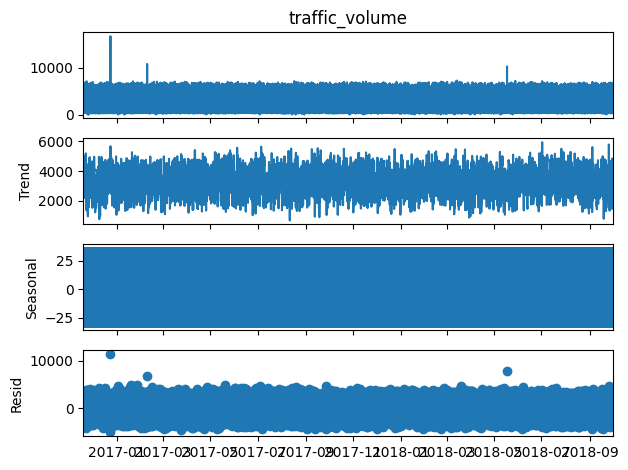

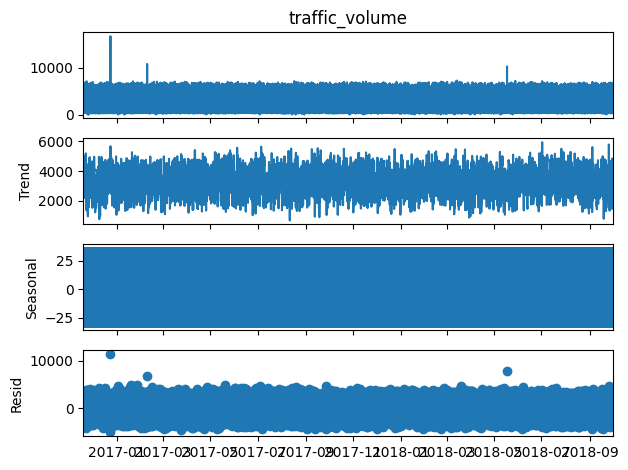

In [185]:
result = seasonal_decompose(df['traffic_volume'], model='additive', period=7)
result.plot()

In [186]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'clouds_all', 'weather_main',
       'weather_description'],
      dtype='object')

In [187]:
# Before delving deep into other visuals let's chech our data for outliers:
fig = px.box(df, y = 'traffic_volume')
fig.show()

In [188]:
# Before delving deep into other visuals let's chech our data for outliers:
fig = px.box(df, y = 'temp')
fig.show()

In [189]:
# Before delving deep into other visuals let's chech our data for outliers:
fig = px.box(df, y = 'rain_1h')
fig.show()

In [190]:
# Before delving deep into other visuals let's chech our data for outliers:
fig = px.box(df, y = 'clouds_all')
fig.show()

In [191]:
# After analyzing the box plots it is obvious that the rain_1h is dominated by zeros producing small outliers, we'll try to deal with them using a quantile transformer or a normal scaling technique if enough time was avalible.

In [192]:
# Let's decompose our visual analysis:
# First we'll plot the whole entire series and then we'll decompose.
fig = px.line(data_frame = df, x = df.index, y = 'traffic_volume')
fig.show()

In [193]:
# Let's analyse our december data:
fig = px.line(data_frame = df.loc['2016-12-01':'2016-12-31'], x = df.loc['2016-12-01':'2016-12-31'].index, y = ['traffic_volume'], color = 'weather_main')
fig.update_layout(
    title = 'December traffic volume analysis',
    xaxis_title="Date",
    yaxis_title="Traffic volume"
    )
fig.show()

In [194]:
# Let's analyse our december data by the day:
fig = px.line(data_frame = df.loc['2016-12-01':'2016-12-31'], x = df.loc['2016-12-01':'2016-12-31'].index.day, y = ['traffic_volume'], color = 'weather_main')
fig.update_layout(
    title = 'December traffic volume analysis by the day',
    xaxis_title="Day",
    yaxis_title="Traffic volume"
    )
fig.show()

In [195]:
# Let's analyse our december data by the hour:
fig = px.line(data_frame = df.loc['2016-12-01':'2016-12-31'], x = df.loc['2016-12-01':'2016-12-31'].index.hour, y = ['traffic_volume'], color = 'weather_main')
fig.update_layout(
    title = 'December traffic volume analysis by the hour',
    xaxis_title="hour",
    yaxis_title="Traffic volume"
    )
fig.show()

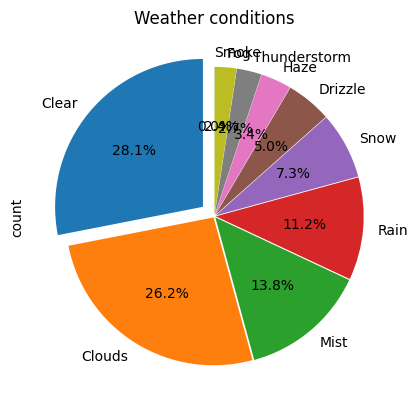

In [196]:
df['weather_main'].value_counts().plot(kind='pie',autopct='%1.1f%%',startangle=90, explode=(0.1, 0.01, 0.01, 0.01, 0.01,0.01,0.01,0.01,0.01,0.01))
plt.title('Weather conditions')
plt.show()

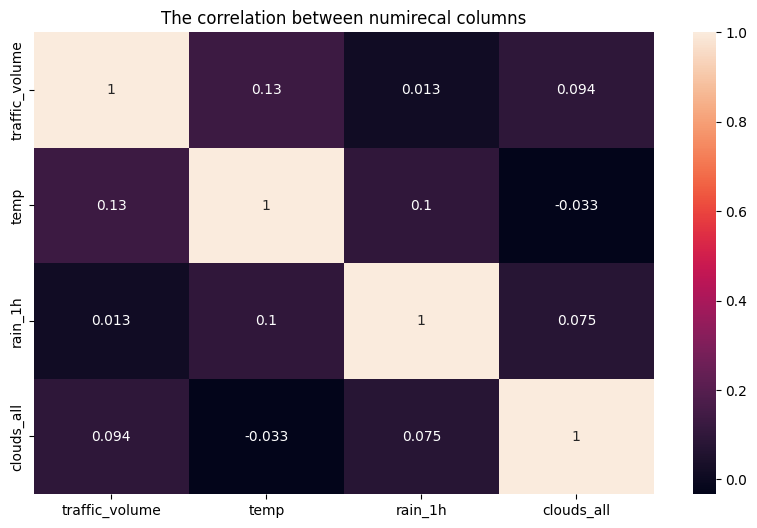

In [197]:
# Let's check the correlation between our data using a heatmap:
num_col = df.select_dtypes(include = ['number'])
plt.figure(figsize = (10,6))
sns.heatmap(num_col.corr(), annot = True)
plt.title('The correlation between numirecal columns')
plt.show()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


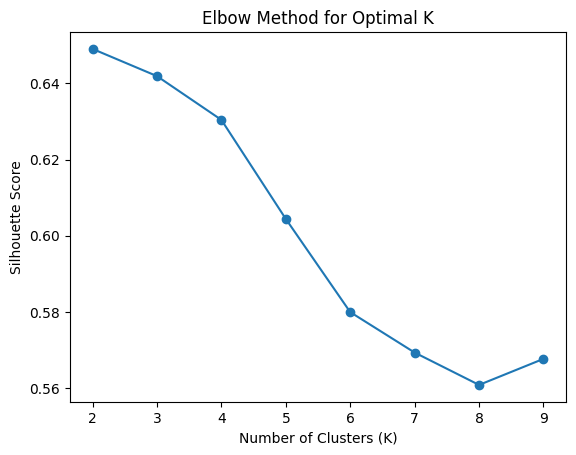

In [198]:
# My idea is to cluster the data and turn this into a clasification case.
df['traffic_volume'].fillna(df['traffic_volume'].mean(), inplace = True)
cdf = df.copy()
cdf.drop(['temp',	'rain_1h',	'clouds_all',	'weather_main',	'weather_description'], axis = 1, inplace = True)
cdf.reset_index()
sil_score = []

for k in range(2,10):
  K_Cluster = KMeans(n_clusters = k)
  K_Cluster.fit(cdf)
  sil_score.append(silhouette_score(cdf, K_Cluster.predict(cdf)))

# Create the elbow plot:
plt.plot(range(2,10), sil_score, marker = 'o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method for Optimal K')
plt.show()


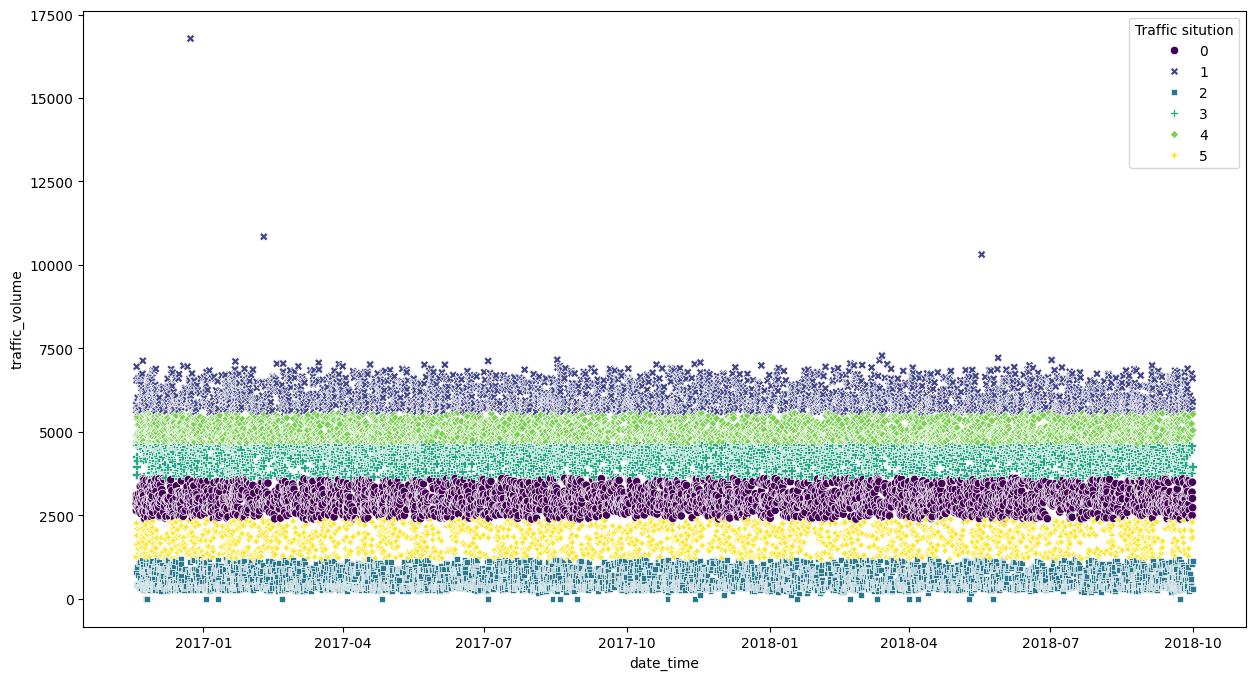

In [199]:
m_cluster = KMeans(n_clusters = 6)
m_cluster.fit(cdf)
m_cluster.predict(cdf)
cluster_labels = m_cluster.labels_
plt.figure(figsize=(15, 8))
cdf['Traffic sitution'] = cluster_labels
sns.scatterplot(x='date_time', y='traffic_volume', hue='Traffic sitution', style = 'Traffic sitution', data=cdf, palette='viridis')
plt.show()


In [200]:
fig = px.scatter(x=cdf.index, y='traffic_volume', color='Traffic sitution', symbol = 'Traffic sitution', data_frame=cdf)
fig.update_layout(
    width = 1200,
    height = 1000,
    title = 'Clustered traffic volumes',
    xaxis_title="Date",
    yaxis_title="Traffic volume"
    )
fig.show()

In [252]:
# Add traffic density column:
traffic_sitution_labels = {
    2: 'Free Flow',
    5:'Light Traffic',
    0:'Moderate Traffic',
    3:'Heavy Traffic',
    4:'Very Heavy Traffic',
    1:'Severe Congestion'
}
cdf['traffic_sitution_labels'] = cdf['Traffic sitution'].map(traffic_sitution_labels)


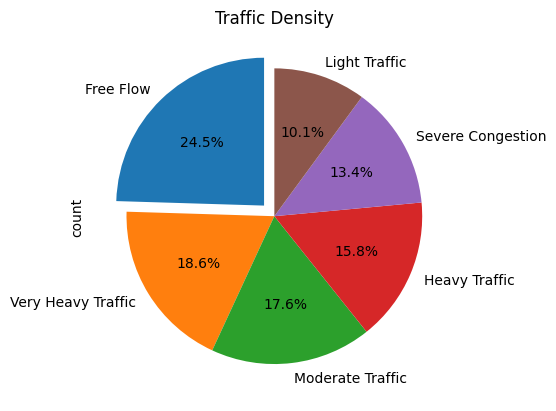

In [253]:
cdf['traffic_sitution_labels'].value_counts().plot(kind='pie',
                                          autopct='%1.1f%%',
                                          startangle=90,
                                          explode=(0.1, 0, 0, 0, 0, 0))
plt.title('Traffic Density')
plt.show()

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [201]:
# After finishing visualization we need to revert the missing data in the traffic_volume feature:
df['traffic_volume'] = df['traffic_volume'].replace(-1,np.nan) # revert it back

In [202]:
# Apply moving average to our data due to the fact that our data has no clear seasonality
df['traffic_volume'] = df['traffic_volume'].rolling(window = 3).mean()
df['traffic_volume'].fillna(method = 'bfill', inplace = True)

In [203]:
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [204]:
# We'll drop cetegorical data:
df.drop(['weather_main', 'weather_description'], axis = 1, inplace = True)

In [205]:
df

,traffic_volume,temp,rain_1h,clouds_all
date_time,,,,
2016-11-18 15:00:00,2353.000000,291.15,0.0,90
2016-11-18 15:00:00,2353.000000,286.01,0.0,1
2016-11-18 15:00:00,2353.000000,293.69,0.0,75
2016-11-18 16:00:00,2896.000000,262.35,0.0,1
2016-11-18 16:00:00,4411.333333,267.08,0.0,5
...,...,...,...,...
2018-09-30 19:00:00,3204.000000,296.42,0.0,40
2018-09-30 20:00:00,5073.000000,285.58,0.0,40
2018-09-30 21:00:00,3250.000000,275.30,0.0,1


In [206]:
# # Before splitting let's prepare the processing pipeline:
# col_tran_steps = [
#     ('Numerical Imputation', IterativeImputer(), ['traffic_volume']),
#     ('Main_scaling', MinMaxScaler(),['traffic_volume']),
#     ('Scaling', MinMaxScaler(), ['temp', 'rain_1h', 'clouds_all']),
# ]
# col_transformer = ColumnTransformer(col_tran_steps)

In [214]:
# Train 60% = 12000 - Validation 15% = 3000, Test 25% = 5000. totaling 20000.
train_val, test_ds = train_test_split(df, test_size = 5000, random_state = 10101010,  shuffle=False)
train_ds, val_ds = train_test_split(train_val, test_size = 3000, random_state = 10101010,  shuffle=False)
train_ds.shape, val_ds.shape, test_ds.shape

((12000, 4), (3000, 4), (5000, 4))

In [215]:
Scaler = MinMaxScaler()
# Fit and transform training:
train_ds = Scaler.fit_transform(train_ds)
# Transform validation and testing without fitting to avoid data leakage:
val_ds = Scaler.transform(val_ds)
test_ds = Scaler.transform(test_ds)


In [209]:
# # Apply preprocossing pipeline:
# # Fit and transform training:
# train_ds = col_transformer.fit_transform(train_ds)
# # Transform validation and testing without fitting to avoid data leakage:
# # Well due to fact that the ordenial encoder can't transform certain strings since it's not the train split we'll have to fit transfrom our data
# val_ds = col_transformer.transform(val_ds)
# test_ds = col_transformer.transform(test_ds)


In [210]:
# Trying to fix the error.
# # Reshape the splits:
# train_ds = train_ds.reshape(-1,1)
# val_ds = val_ds.reshape(-1,1)
# test_ds = test_ds.reshape(-1,1)

In [216]:
# Assign labels to data
from tensorflow.keras.utils import timeseries_dataset_from_array

window = 24 # The window is set to an 6 hours prior prediction.
# We'll set the batch size to 365 as in a year.
train_X_y =timeseries_dataset_from_array(train_ds, targets=train_ds[window: , 0], sequence_length=window) # We specify zero due to the fact that our traffic volume feature is the first.
val_X_y =timeseries_dataset_from_array(val_ds, targets=val_ds[window: , 0], sequence_length=window)
test_X_y =timeseries_dataset_from_array(test_ds, targets=test_ds[window: , 0], sequence_length=window)

In [217]:
# Maybe the issue is null values:
print(np.isnan(train_ds[:, 0]).sum())
print(np.isnan(val_ds[:, 0]).sum())
print(np.isnan(test_ds[:, 0]).sum())


0
0
0


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [ ]:
# DONE

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
# # All right it's never wrong to start with a simpleRNN model am I right?
# # Model 1:
# model = Sequential([
#     # First RNN layer:
#     SimpleRNN(units = 16, activation = 'tanh', return_sequences = True),
#     # Second RNN layer:
#     SimpleRNN(units = 32, activation = 'tanh'),
#     # Dense layer:
#     Dense(32, activation = 'relu'),
#     # Output layer:
#     Dense(1,activation = 'relu') # We'll make the activation as relu to remove negative number prediction.
# ])

In [ ]:
# # All right it's never wrong to start with a simpleRNN model am I right?
# # Model 2:
# model = Sequential([
#     # First RNN layer:
#     SimpleRNN(units = 64, activation = 'tanh', return_sequences = True),
#     # Second RNN layer:
#     SimpleRNN(units = 32, activation = 'tanh'),
#     # Dense layer:
#     Dense(8, activation = 'relu'),
#     # Output layer:
#     Dense(1,activation = 'relu') # We'll make the activation as relu to remove negative number prediction.
# ])

In [218]:
# Model 3, we'll try GRU:
model = Sequential([
      # First GRU layer:
      GRU(units = 50, activation = 'tanh', return_sequences = True),
      # Second GRU layer:
      GRU(units = 50, activation = 'tanh', return_sequences = True),
      # Third GRU layer:
      GRU(units = 50, activation = 'tanh', return_sequences = True),
      # Fourth GRU layer:
      GRU(units = 50, activation = 'tanh', return_sequences = True),
      # Fifth GRU layer:
      GRU(units = 50, activation = 'tanh'),
      # Dense layer 1:
      Dense(32, activation = 'relu'),
      # Dense layer 2:
      Dense(64, activation = 'relu'),
      # Output layer:
      Dense(1,activation = 'relu') # We'll make the activation as relu to remove negative number prediction.
 ])

In [219]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae']) # we'll try mae as a metric first if it doesn't suit the data we'll try r2.

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [220]:
history = model.fit(train_X_y, epochs = 100, validation_data = val_X_y)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0319 - mae: 0.1390 - val_loss: 0.0171 - val_mae: 0.1066
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0174 - mae: 0.1067 - val_loss: 0.0130 - val_mae: 0.0925
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0113 - mae: 0.0868 - val_loss: 0.0087 - val_mae: 0.0770
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0090 - mae: 0.0786 - val_loss: 0.0075 - val_mae: 0.0730
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0074 - mae: 0.0727 - val_loss: 0.0066 - val_mae: 0.0701
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0070 - mae: 0.0715 - val_loss: 0.0065 - val_mae: 0.0696
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0069 - mae: 0.0710 - val_loss: 0.0065 - val_mae: 0.0694
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0068 - mae: 0.0707 - val_loss: 0.0064 - val_mae: 0.0693
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - lo

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [ ]:
# MODEL 3:

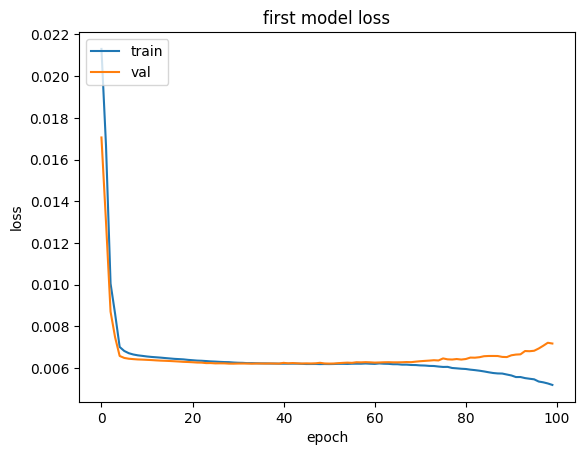

In [221]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('third model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

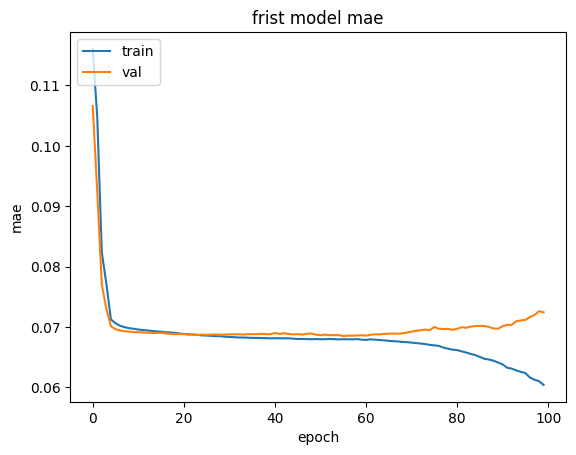

In [222]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('third model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
# Model testing predictions:

In [224]:
X_test, y_test = next(iter(test_X_y))
X_test.shape, y_test.shape

(TensorShape([128, 24, 4]), TensorShape([128]))

In [225]:
y_pred = model.predict(X_test)
# y_pred = col_transformer.named_transformers_.Main_scaling.inverse_transform(y_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


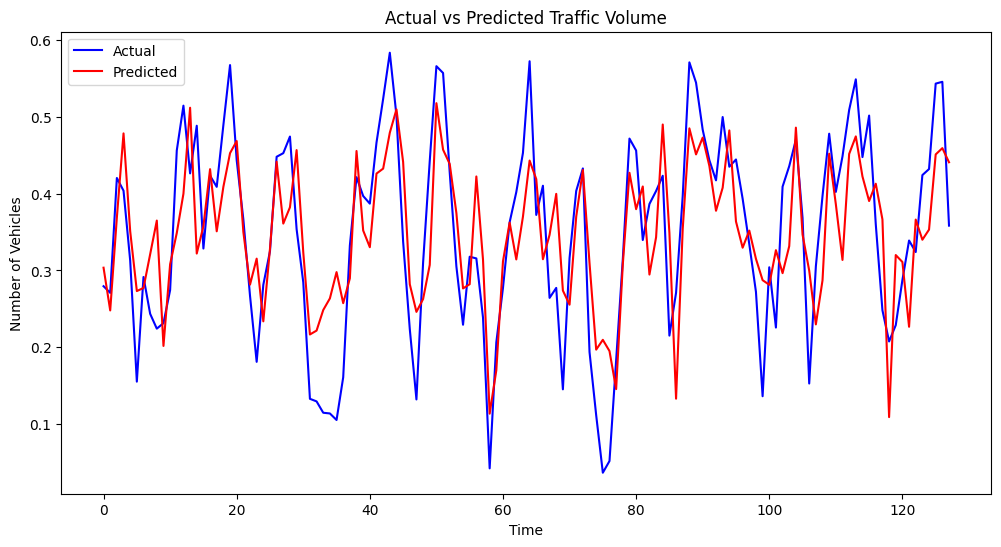

In [226]:
y_pred = model.predict(X_test)
# y_pred = col_transformer.named_transformers_.Main_scaling.inverse_transform(y_pred)
# Model 3 evalution:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [ ]:
# Done at the top

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [234]:
# Model 2.1, we'll try GRU:
model = Sequential([
      # First GRU layer:
      SimpleRNN(units = 16, activation = 'tanh', return_sequences = True),
      # Second GRU layer:
      SimpleRNN(units = 32, activation = 'tanh', return_sequences = True),
      # Third GRU layer:
      SimpleRNN(units = 64, activation = 'tanh', return_sequences = True),
      # Fourth GRU layer:
      SimpleRNN(units = 128, activation = 'tanh', return_sequences = True),
      # # Fifth GRU layer:
      # LSTM(units = , activation = 'tanh'),
      # Dense layer 1:
      Dense(32, activation = 'relu'),
      # Dense layer 2:
      Dense(64, activation = 'relu'),
      # Output layer:
      Dense(1,activation = 'relu') # We'll make the activation as relu to remove negative number prediction.
 ])

In [235]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

In [236]:
history = model.fit(train_X_y, epochs = 50, validation_data = val_X_y)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 0.0378 - mae: 0.1493 - val_loss: 0.0177 - val_mae: 0.1081
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0187 - mae: 0.1108 - val_loss: 0.0173 - val_mae: 0.1074
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0184 - mae: 0.1099 - val_loss: 0.0173 - val_mae: 0.1075
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0181 - mae: 0.1091 - val_loss: 0.0173 - val_mae: 0.1075
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0181 - mae: 0.1089 - val_loss: 0.0173 - val_mae: 0.1075
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0180 - mae: 0.1088 - val_loss: 0.0173 - val_mae: 0.1075
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0180 - mae: 0.1087 - val_loss: 0.0173 - val_mae: 0.1075
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0180 - mae: 0.1087 - val_loss: 0.0173 - val_mae: 0.1075
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

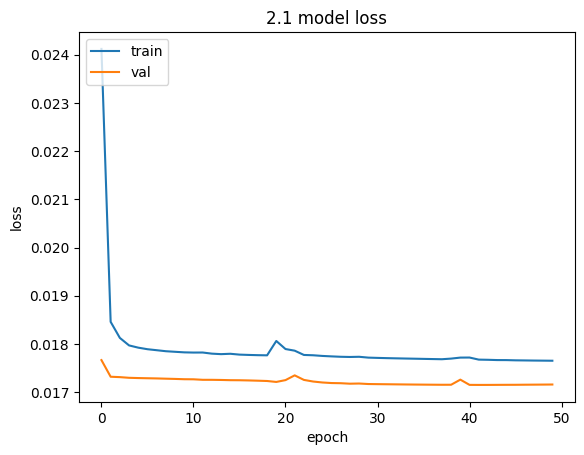

In [237]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('2.1 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

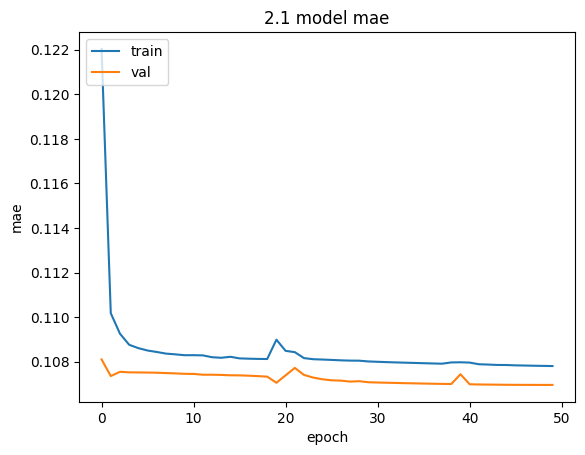

In [238]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('2.1 model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [239]:
X_test, y_test = next(iter(test_X_y))
X_test.shape, y_test.shape

(TensorShape([128, 24, 4]), TensorShape([128]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


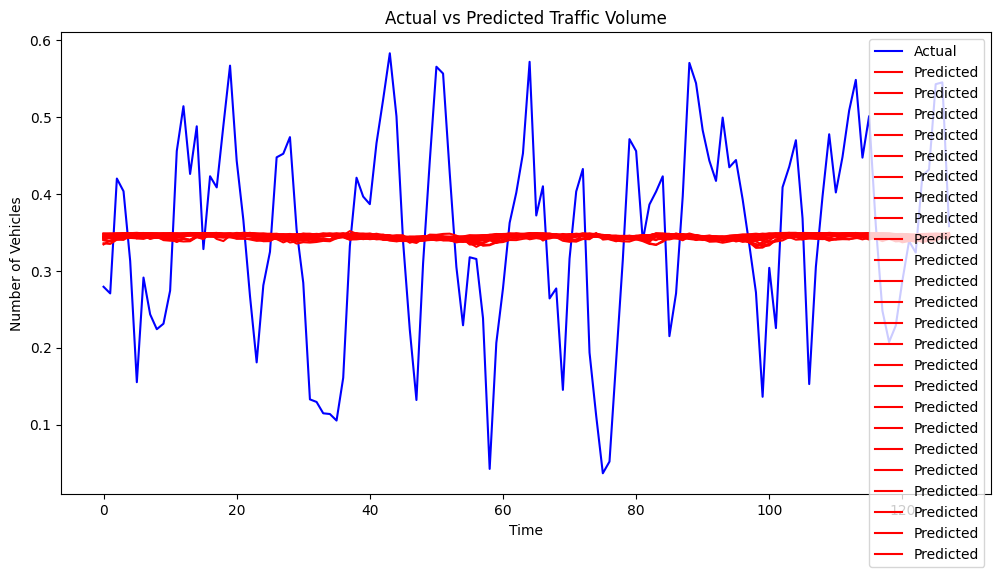

In [241]:
y_pred = model.predict(X_test)
y_pred_2d = y_pred.reshape(y_pred.shape[0], -1)
# y_pred = col_transformer.named_transformers_.Main_scaling.inverse_transform(y_pred)
# Model 3 evalution:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred_2d, label='Predicted', color='red')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

1.   At first I used a pipline to handle my data including all the preprocessing steps needed, but then after dropping categorical columns due to the model's underperformance, proceeding to use a normal minmax scaler with numerical features
2.   I had an idea to turn this into a clasification case by binning data using KMeans clustiring but sadly I couldn't try due to the time constraint.



3.   When building a model it's really about triel and error, so trying many different layers and techniques really depends on the model's state.
4.  The adam optimizer proved again and agian that's it far and away the best DEFUALT optimizer so as we like to say in this field you should really try all the options as you can't really understand the blackbox that is your model. Now for the number of epochs it really dependeds on the performance of my laptop and how much it can handle, batch size is unspecefied as it sets different batch sizes to every epoch





5.   Since the subject at hand was a regression case with I chose the loss function (mse) as it best expresses the the model's performance.
6.   I changed the window size amples of time to find out what is the reason of the model's underfitting, other than that nothing else was done.




7.   Ah the bias and varience tradeoff the nightmare that keeps huanting me, overfitting could occur for many reassons, if our data was imbalanced that could easily lead to overfitting, if our model was too complex for a given dataset that will most likely lead to overfitting my main issue here was the underfitting althogh I tried quite the complex models for this data set it didn't help what so ever so by the end I chose to use the moving average as the main issue is most likely the data and it somewhat helped.
8.   Welp... there is alot to improve honestly, although I really did try everything I have to offer from various types of preprocessing techniques to complex models nothing seemed to work, I'll say that the idea od turning this to a clasification case after binning our data using the unsupervised kmeans clustiring algorethim is absolutely an interesting approuch to solve the issue in my modeling.

Thanks and sorry for any typos.


